<a href="https://colab.research.google.com/github/jasleenkaursandhu/Reproducing-chest-xray-report-generation-boag/blob/main/nlg_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Successfully imported custom pycocoevalcap3 metrics
Loading reference texts from /Users/simeon/Documents/DLH/content/mimic-cxr-project/output/reference.tsv
Loaded reference texts for 1757 test images

Loading random predictions from /Users/simeon/Documents/DLH/content/mimic-cxr-project/output/random.tsv
Loaded 1757 predictions

Evaluating random model...
Number of cases with both reference and prediction: 1757
{'testlen': 93640, 'reflen': 91118, 'guess': [93640, 91883, 90126, 88370], 'correct': [21512, 4770, 1392, 533]}
ratio: 1.027678395048168
random BLEU scores (n=1757):
  BLEU-1: 0.2297
  BLEU-2: 0.1092
  BLEU-3: 0.0569
  BLEU-4: 0.0325
random CIDEr score (scaled): 0.5527

Loading 1-gram predictions from /Users/simeon/Documents/DLH/content/mimic-cxr-project/output/1-gram.tsv
Loaded 1757 predictions

Evaluating 1-gram model...
Number of cases with both reference and prediction: 1757
{'testlen': 75096, 'reflen': 91118, 'guess': [75096, 73339, 71641, 69969], 'correct': [17060, 431, 4, 

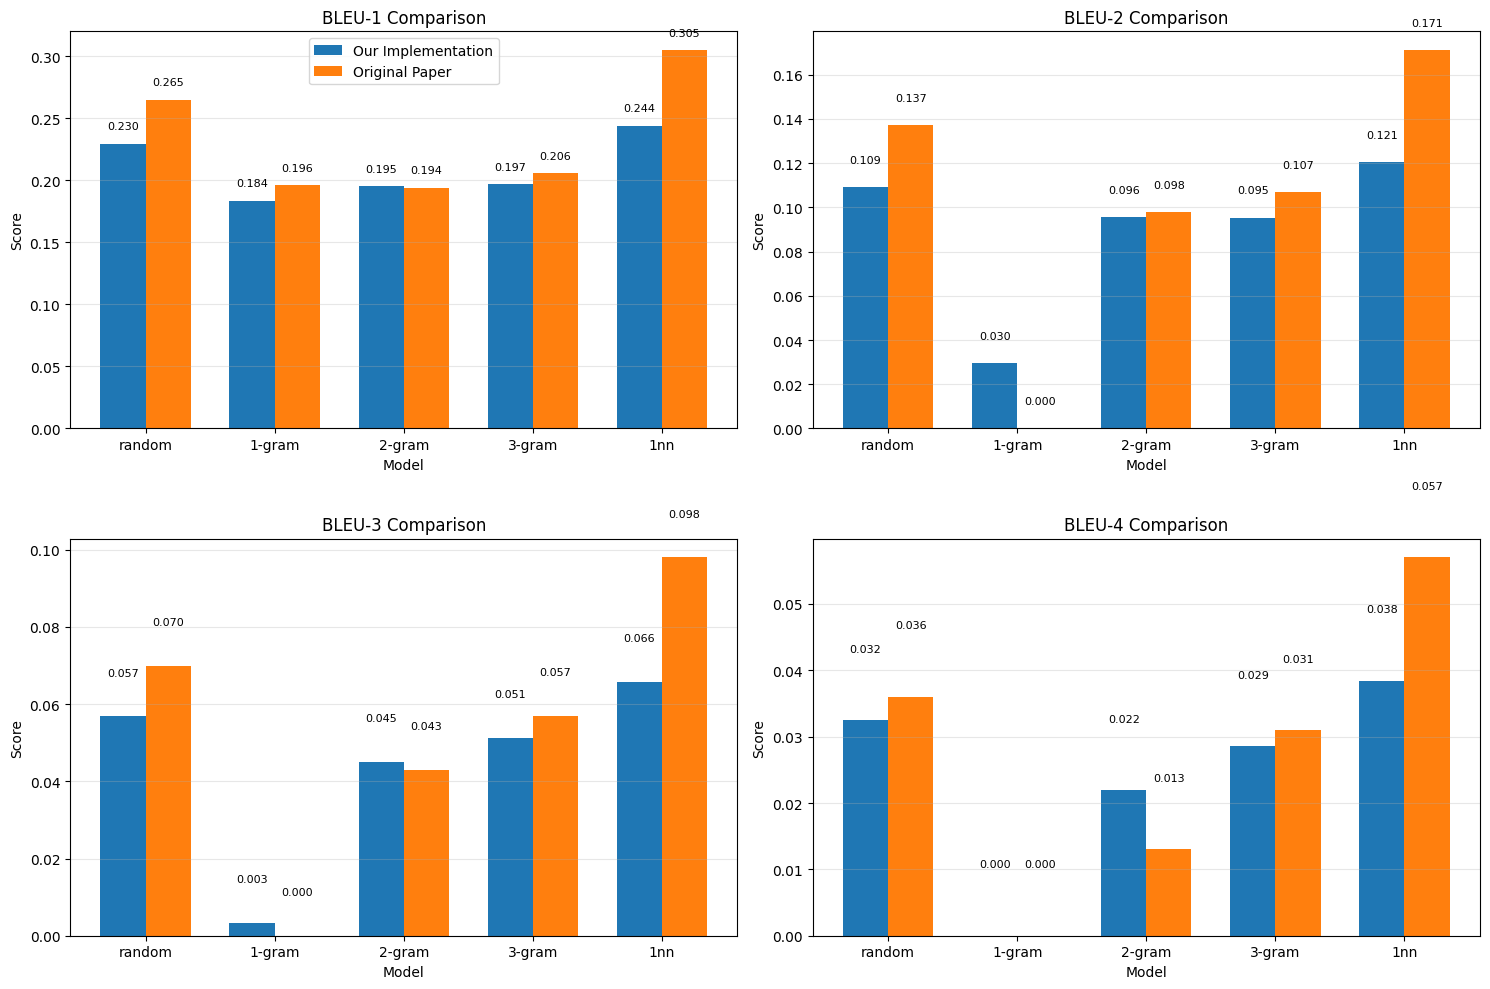

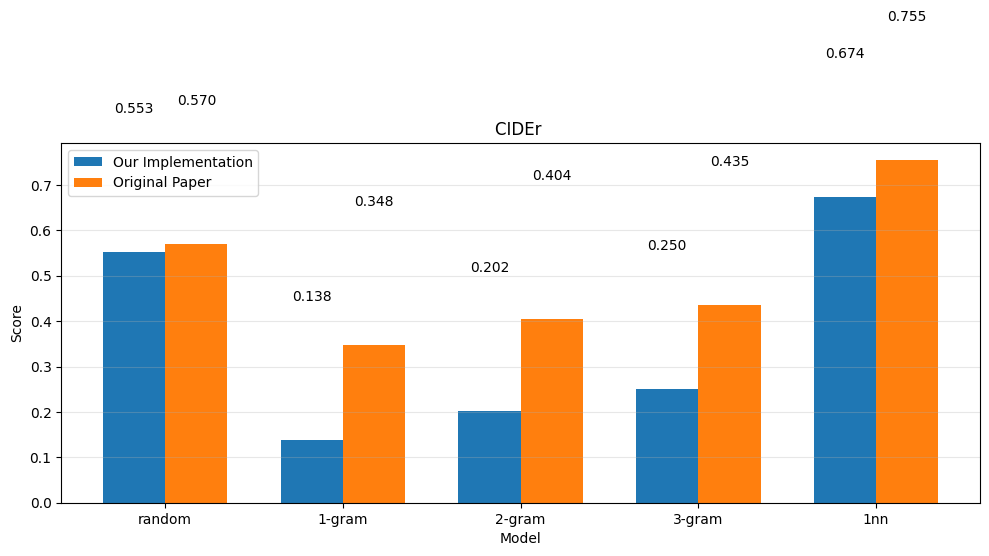

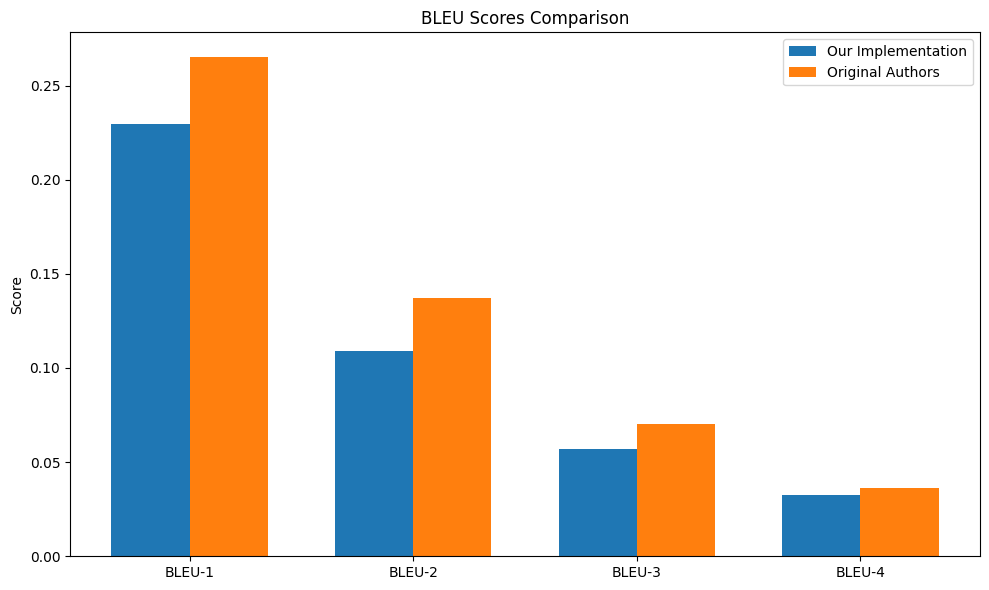

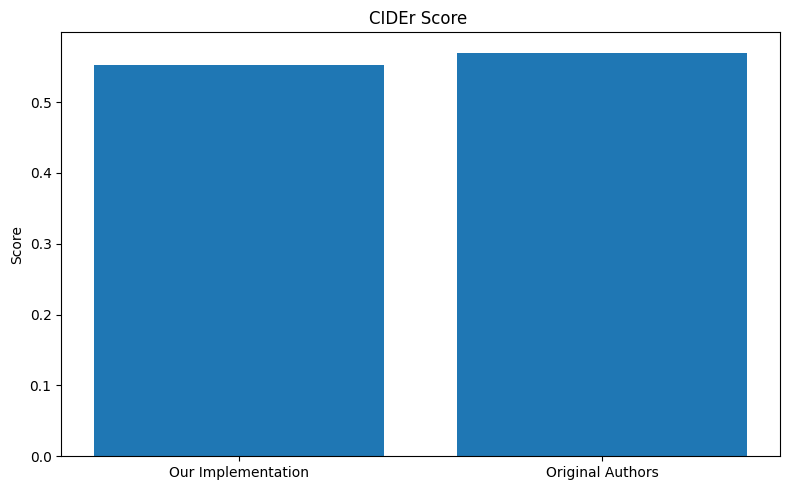

BLEU-1: Ours = 0.2297, Authors = 0.2650
BLEU-4: Ours = 0.0325, Authors = 0.0360
CIDEr Ours = 0.5527, Authors = 0.5700
Evaluating N-gram model with NLG metrics
3-gram predictions shape: (1757, 2)
Number of cases with both reference and 3-gram prediction: 1757
2025-04-23 17:16:21
{'testlen': 79581, 'reflen': 91118, 'guess': [79581, 77824, 76069, 74314], 'correct': [18139, 4149, 1301, 424]}
ratio: 0.8733839636515192
3-gram BLEU scores (n=1757): [0.19717120943261518, 0.0953578540314666, 0.05123979218704314, 0.02854560239554096]
3-gram CIDEr score 0.2504
2025-04-23 17:16:22


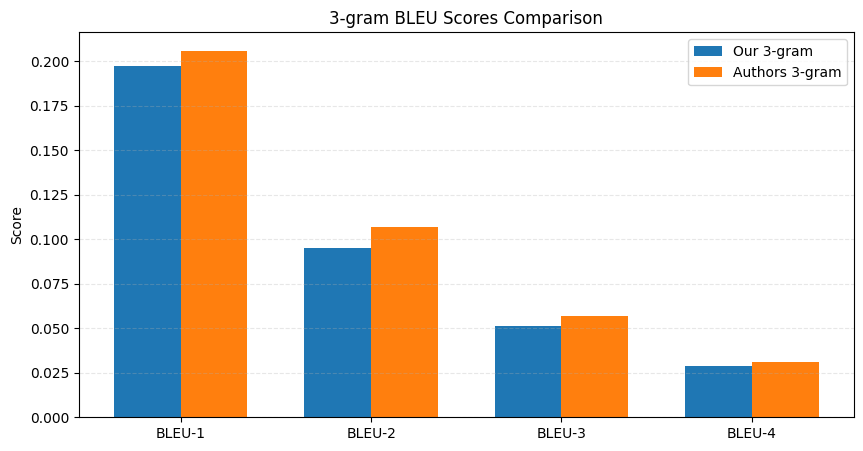

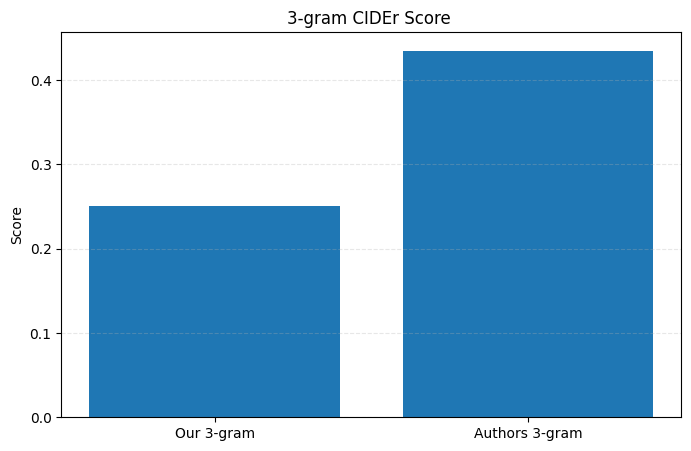

3-gram BLEU scores comparison:
  BLEU-1: Ours = 0.1972, Authors = 0.2060
  BLEU-2: Ours = 0.0954, Authors = 0.1070
  BLEU-3: Ours = 0.0512, Authors = 0.0570
  BLEU-4: Ours = 0.0285, Authors = 0.0310

3-gram CIDEr score comparison 
  Ours = 0.2504, Authors = 0.4350
2025-04-23 17:16:22
Evaluating KNN model with NLG metrics
KNN predictions shape: (1757, 2)
Number of cases with both reference and KNN prediction: 1757
2025-04-23 17:16:22
{'testlen': 89638, 'reflen': 91118, 'guess': [89638, 87881, 86128, 84375], 'correct': [22242, 5325, 1710, 659]}
ratio: 0.9837573256656096
KNN BLEU scores (n=1757): [0.24406814775887667, 0.12060979438439513, 0.06573784196195281, 0.03843588153445101]
KNN CIDEr score 0.6740
2025-04-23 17:16:23


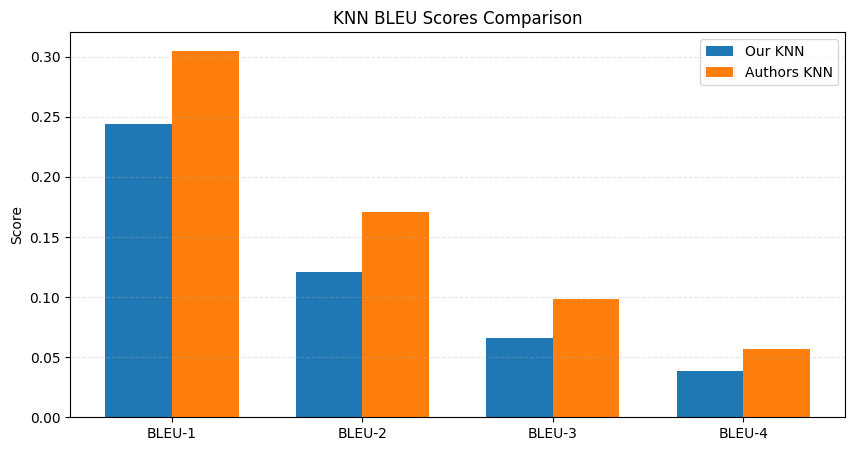

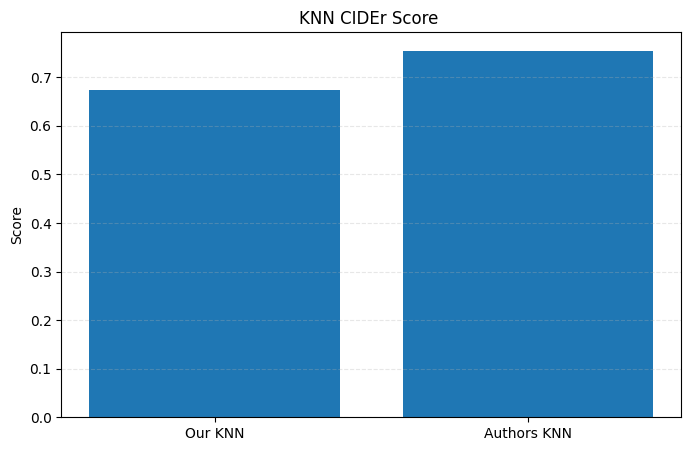

KNN BLEU scores comparison:
  BLEU-1: Ours = 0.2441, Authors = 0.3050
  BLEU-2: Ours = 0.1206, Authors = 0.1710
  BLEU-3: Ours = 0.0657, Authors = 0.0980
  BLEU-4: Ours = 0.0384, Authors = 0.0570

KNN CIDEr score comparison 
  Ours = 0.6740, Authors = 0.7550


In [6]:
# NLG Evaluation for Chest X-Ray Report Generation Models
# This notebook evaluates model outputs using BLEU and CIDEr metrics

import numpy as np
import pandas as pd
import subprocess
import os
import sys
from collections import defaultdict
import tqdm
from time import strftime, gmtime
import matplotlib.pyplot as plt
base_path = '/Users/simeon/Documents/DLH/content/mimic-cxr-project'
# Clone the interpretable-report-gen repository if it doesn't exist
repo_path = os.path.join(base_path, 'interpretable-report-gen')
if not os.path.exists(repo_path):
    print("Cloning interpretable-report-gen repository...")
    subprocess.run(['git', 'clone', 'https://github.com/stmharry/interpretable-report-gen.git', repo_path])
    print("Repository cloned successfully.")

# Add the repository path to the system path so we can import from it
if repo_path not in sys.path:
    sys.path.append(repo_path)

# Try to import the custom pycocoevalcap3 modules
try:
    sys.path.append(os.path.join(repo_path, 'pycocoevalcap3'))
    from pycocoevalcap3.bleu.bleu import Bleu
    from pycocoevalcap3.cider.cider import Cider
    print("Successfully imported custom pycocoevalcap3 metrics")
except ImportError as e:
    print(f"Error importing custom pycocoevalcap3: {e}")
    print("Falling back to standard pycocoevalcap")
    from pycocoevalcap.bleu.bleu import Bleu
    from pycocoevalcap.cider.cider import Cider

# Define paths
base_path = '/Users/simeon/Documents/DLH/content/mimic-cxr-project'
data_dir = os.path.join(base_path, 'data')
output_dir = os.path.join(base_path, 'output')

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Helper function to ensure all values are strings
def ensure_string(item):
    if item is None:
        return ""
    return str(item)

# Function to evaluate a model using NLG metrics
def evaluate_model(model_name, references, predictions):
    """
    Evaluate a model using BLEU and CIDEr metrics

    Args:
        model_name (str): Name of the model being evaluated
        references (dict): Dictionary of reference texts
        predictions (dict): Dictionary of model predictions

    Returns:
        tuple: BLEU scores and CIDEr score
    """
    print(f"\nEvaluating {model_name} model...")

    # Find common IDs between reference and predictions
    common_ids = set(references.keys()) & set(predictions.keys())
    print(f"Number of cases with both reference and prediction: {len(common_ids)}")

    # Filter to keep only common IDs
    references_filtered = {k: references[k] for k in common_ids}
    predictions_filtered = {k: predictions[k] for k in common_ids}

    # Calculate BLEU scores
    bleu_scorer = Bleu(4)
    bleu_score = bleu_scorer.compute_score(references_filtered, predictions_filtered)
    print(f"{model_name} BLEU scores (n={len(predictions_filtered)}):")
    print(f"  BLEU-1: {bleu_score[0][0]:.4f}")
    print(f"  BLEU-2: {bleu_score[0][1]:.4f}")
    print(f"  BLEU-3: {bleu_score[0][2]:.4f}")
    print(f"  BLEU-4: {bleu_score[0][3]:.4f}")

    # Calculate CIDEr score
    cider_scorer = Cider(4)
    cider_score = cider_scorer.compute_score(references_filtered, predictions_filtered)
    # Scale CIDEr score by 10
    scaled_cider_score = cider_score[0] * 10
    print(f"{model_name} CIDEr score (scaled): {scaled_cider_score:.4f}")

    return bleu_score[0], scaled_cider_score

# Load reference/ground truth data
reference_path = os.path.join(output_dir, 'reference.tsv')
if not os.path.exists(reference_path):
    # If reference file doesn't exist, create it from test data
    print("Reference file not found. Extracting from test data...")

    # Import the report parser module to extract text from reports
    sys.path.append(f"{base_path}/modules")
    from report_parser import parse_report

    # Load test data
    test_df = pd.read_csv(os.path.join(data_dir, 'test.tsv'), sep='\t')

    # Extract findings from reports
    reports_dir = os.path.join(base_path, 'reports')

    # Create a dictionary to store the report text for each dicom_id
    reference_texts = {}

    for _, row in tqdm.tqdm(test_df.iterrows(), total=len(test_df)):
        dicom_id = row['dicom_id']
        study_id = row['study_id']
        subject_id = row['subject_id']

        # Construct path to the report
        subject_prefix = f"p{str(subject_id)[:2]}"
        subject_dir = f"p{subject_id}"
        study_dir = f"s{study_id}"
        report_path = os.path.join(reports_dir, 'files', subject_prefix, subject_dir, f"{study_dir}.txt")

        # Parse the report
        try:
            if os.path.exists(report_path):
                report = parse_report(report_path)

                # If the report has a findings section, add it
                if 'findings' in report:
                    reference_texts[dicom_id] = report['findings']
        except Exception as e:
            print(f"Error parsing report for {dicom_id}: {e}")

    # Save references to a TSV file
    reference_df = pd.DataFrame({
        'dicom_id': list(reference_texts.keys()),
        'text': list(reference_texts.values())
    })

    reference_df.to_csv(reference_path, sep='\t', index=False)
    print(f"Saved reference texts for {len(reference_texts)} test images to {reference_path}")
else:
    print(f"Loading reference texts from {reference_path}")
    reference_df = pd.read_csv(reference_path, sep='\t')
    print(f"Loaded reference texts for {len(reference_df)} test images")

# Create references dictionary in the format expected by the evaluation metrics
references = {k: [ensure_string(v)] for k, v in reference_df[['dicom_id', 'text']].values}

# Define the models to evaluate
models_to_evaluate = ['random', '1-gram', '2-gram', '3-gram', '1nn']

# Authors' results from the paper (hardcoded) - Scale CIDEr by 10
paper_results = {
    'random': {
        'bleu': [0.265, 0.137, 0.070, 0.036],
        'cider': 0.570 
    },
    '1-gram': {
        'bleu': [0.196, 0.000, 0.000, 0.000],
        'cider': 0.348 
    },
    '2-gram': {
        'bleu': [0.194, 0.098, 0.043, 0.013],
        'cider': 0.404 
    },
    '3-gram': {
        'bleu': [0.206, 0.107, 0.057, 0.031],
        'cider': 0.435 
    },
    '1nn': {
        'bleu': [0.305, 0.171, 0.098, 0.057],
        'cider': 0.755 
    }
}

# Dictionary to store our results
our_results = {}

# Evaluate each model
for model in models_to_evaluate:
    # Adjust file name based on model
    file_name = f"{model}.tsv"
    if model == '1nn':
        file_name = "1nn_reports.tsv"  # Adjust based on how you named your 1-NN output file

    model_path = os.path.join(output_dir, file_name)

    if os.path.exists(model_path):
        print(f"\nLoading {model} predictions from {model_path}")
        model_df = pd.read_csv(model_path, sep='\t')
        print(f"Loaded {len(model_df)} predictions")

        # Convert to format expected by evaluation metrics
        column_name = 'generated' if 'generated' in model_df.columns else 'prediction'
        predictions = {k: [ensure_string(v)] for k, v in model_df[['dicom_id', column_name]].values}

        # Evaluate the model
        bleu_scores, cider_score = evaluate_model(model, references, predictions)

        # Store results
        our_results[model] = {
            'bleu': bleu_scores,
            'cider': cider_score
        }
    else:
        print(f"\nWarning: {model} predictions file not found at {model_path}")
        print(f"Skipping evaluation for {model}")

# Create comparison visualizations
print("\nCreating comparison visualizations...")

# Create BLEU comparison plot
plt.figure(figsize=(15, 10))

for i, metric in enumerate(['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4']):
    plt.subplot(2, 2, i+1)

    # Data for plot
    models = list(our_results.keys())
    our_scores = [our_results[model]['bleu'][i] for model in models]
    paper_scores = [paper_results[model]['bleu'][i] for model in models]

    x = range(len(models))
    width = 0.35

    # Create bars
    plt.bar([i - width/2 for i in x], our_scores, width, label='Our Implementation')
    plt.bar([i + width/2 for i in x], paper_scores, width, label='Original Paper')

    # Add labels
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.title(f'{metric} Comparison')
    plt.xticks(x, models)
    plt.grid(axis='y', alpha=0.3)

    # Add values on top of bars
    for j, v in enumerate(our_scores):
        plt.text(j - width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

    for j, v in enumerate(paper_scores):
        plt.text(j + width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

    if i == 0:  # Only add legend on the first subplot
        plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'bleu_comparison.png'))

# Create CIDEr comparison plot
plt.figure(figsize=(10, 6))

# Data for plot
models = list(our_results.keys())
our_cider = [our_results[model]['cider'] for model in models]
paper_cider = [paper_results[model]['cider'] for model in models]

x = range(len(models))
width = 0.35

# Create bars
plt.bar([i - width/2 for i in x], our_cider, width, label='Our Implementation')
plt.bar([i + width/2 for i in x], paper_cider, width, label='Original Paper')

# Add labels
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('CIDEr ')
plt.xticks(x, models)
plt.grid(axis='y', alpha=0.3)

# Add values on top of bars
for j, v in enumerate(our_cider):
    plt.text(j - width/2, v + 0.3, f'{v:.3f}', ha='center', va='bottom')

for j, v in enumerate(paper_cider):
    plt.text(j + width/2, v + 0.3, f'{v:.3f}', ha='center', va='bottom')

plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'cider_comparison.png'))

# Create a summary table
print("\nSummary of results compared to the paper:")
summary_data = []

for model in models_to_evaluate:
    if model in our_results:
        row = {
            'Model': model,
            'BLEU-1 (Ours)': our_results[model]['bleu'][0],
            'BLEU-1 (Paper)': paper_results[model]['bleu'][0],
            'BLEU-2 (Ours)': our_results[model]['bleu'][1],
            'BLEU-2 (Paper)': paper_results[model]['bleu'][1],
            'BLEU-3 (Ours)': our_results[model]['bleu'][2],
            'BLEU-3 (Paper)': paper_results[model]['bleu'][2],
            'BLEU-4 (Ours)': our_results[model]['bleu'][3],
            'BLEU-4 (Paper)': paper_results[model]['bleu'][3],
            'CIDEr (Ours)': our_results[model]['cider'],
            'CIDEr (Paper)': paper_results[model]['cider']
        }
        summary_data.append(row)
    else:
        print(f"No results for {model}, skipping in summary table")

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Save summary table
summary_df.to_csv(os.path.join(output_dir, 'evaluation_summary.csv'), index=False)
print(f"\nSaved summary table to {os.path.join(output_dir, 'evaluation_summary.csv')}")
print("All visualizations have been generated and saved to the output directory.")

# Evaluate Random model with NLG metrics
print("Evaluating Random model with NLG metrics")

# Load reference and prediction files
df_gt = pd.read_csv(os.path.join(output_dir, 'reference.tsv'), sep='\t')
df_random = pd.read_csv(os.path.join(output_dir, 'random.tsv'), sep='\t')

print(f"Reference data shape: {df_gt.shape}")
print(f"Random predictions shape: {df_random.shape}")

# Convert to the format expected by the evaluation metrics
references_random = {k:[v] for k,v in df_gt[['dicom_id','text']].values}
pred_random = {k:[v] for k,v in df_random[['dicom_id','generated']].values}

# Find common IDs between reference and predictions
common_ids = set(references_random.keys()) & set(pred_random.keys())
print(f"Number of cases with both reference and prediction: {len(common_ids)}")

# Keep only common IDs
references_filtered = {k:references_random[k] for k in common_ids}
pred_random_filtered = {k:pred_random[k] for k in common_ids}

methods = {'random': pred_random_filtered}

# Calculate BLEU scores
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))

for method, pred in methods.items():
    bleu_scorer = Bleu(4)
    bleu_score = bleu_scorer.compute_score(references_filtered, pred)
    print(f'\t{method:10} (n={len(pred):6d}): {bleu_score[0]}')

    # Store our dynamically calculated results
    our_random_bleu = bleu_score[0]

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))

# Calculate CIDEr scores
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))

for method, pred in methods.items():
    cider_scorer = Cider(4)
    cider_score = cider_scorer.compute_score(references_filtered, pred)
    # Scale CIDEr score by 10
    scaled_cider_score = cider_score[0] * 10
    print(f'\t{method:10} (n={len(pred):6d}): {scaled_cider_score:.4f} ')

    # Store our dynamically calculated results
    our_random_cider = scaled_cider_score

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))

# Random model: Comparing our result to the authors.
# Our results are dynamic, authors' results are hardcoded

# Authors' results (hardcoded)
authors_random_bleu = [0.265, 0.137, 0.070, 0.036]
authors_random_cider = 0.570 

# Create figure for BLEU scores
plt.figure(figsize=(10, 6))
width = 0.35
x = np.arange(4)

plt.bar(x - width/2, our_random_bleu, width, label='Our Implementation')
plt.bar(x + width/2, authors_random_bleu, width, label='Original Authors')

plt.ylabel('Score')
plt.title('BLEU Scores Comparison')
plt.xticks(x, ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4'])
plt.legend()

plt.tight_layout()
plt.savefig('/Users/simeon/Documents/DLH/content/mimic-cxr-project/output/random_bleu_comparison.png')
plt.show()

# Create figure for CIDEr scores
plt.figure(figsize=(8, 5))
plt.bar(['Our Implementation', 'Original Authors'], [our_random_cider, authors_random_cider])
plt.ylabel('Score')
plt.title('CIDEr Score ')

plt.tight_layout()
plt.savefig('/Users/simeon/Documents/DLH/content/mimic-cxr-project/output/random_cider_comparison.png')
plt.show()

# Print simple comparison
print("BLEU-1: Ours = {:.4f}, Authors = {:.4f}".format(our_random_bleu[0], authors_random_bleu[0]))
print("BLEU-4: Ours = {:.4f}, Authors = {:.4f}".format(our_random_bleu[3], authors_random_bleu[3]))
print("CIDEr Ours = {:.4f}, Authors = {:.4f}".format(our_random_cider, authors_random_cider))

# Evaluate N-gram model with NLG metrics
print("Evaluating N-gram model with NLG metrics")

# Load 3-gram predictions
df_3gram = pd.read_csv(os.path.join(output_dir, '3-gram.tsv'), sep='\t')
print(f"3-gram predictions shape: {df_3gram.shape}")

# Convert to the format expected by evaluation metrics
pred_3gram = {k:[v] for k,v in df_3gram[['dicom_id','generated']].values}

# Find common IDs between reference and 3-gram predictions
common_ids_3gram = set(references.keys()) & set(pred_3gram.keys())
print(f"Number of cases with both reference and 3-gram prediction: {len(common_ids_3gram)}")

# Keep only common IDs
references_filtered_3gram = {k:references[k] for k in common_ids_3gram}
pred_3gram_filtered = {k:pred_3gram[k] for k in common_ids_3gram}

# Calculate BLEU scores for 3-gram model
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
bleu_scorer = Bleu(4)
bleu_score_3gram = bleu_scorer.compute_score(references_filtered_3gram, pred_3gram_filtered)
print(f"3-gram BLEU scores (n={len(pred_3gram_filtered)}): {bleu_score_3gram[0]}")

# Store our dynamically calculated results
our_3gram_bleu = bleu_score_3gram[0]

# Calculate CIDEr score for 3-gram model
cider_scorer = Cider(4)
cider_score_3gram = cider_scorer.compute_score(references_filtered_3gram, pred_3gram_filtered)
# Scale CIDEr score by 10
scaled_cider_score_3gram = cider_score_3gram[0] * 10
print(f"3-gram CIDEr score {scaled_cider_score_3gram:.4f}")

# Store our dynamically calculated results
our_3gram_cider = scaled_cider_score_3gram
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))

# N-Gram model: Comparing our result to the authors.
# Our results are dynamic, authors' results are hardcoded

# Authors' n-gram results from the paper (hardcoded)
authors_3gram_bleu = [0.206, 0.107, 0.057, 0.031]
authors_3gram_cider = 0.435 

# Create figure for BLEU scores
plt.figure(figsize=(10, 5))
width = 0.35
x = np.arange(4)

# Plot BLEU scores
plt.bar(x - width/2, our_3gram_bleu, width, label='Our 3-gram')
plt.bar(x + width/2, authors_3gram_bleu, width, label='Authors 3-gram')

plt.ylabel('Score')
plt.title('3-gram BLEU Scores Comparison')
plt.xticks(x, ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4'])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.savefig(os.path.join(output_dir, 'ngram_bleu_comparison.png'))
plt.show()

# Create figure for CIDEr scores
plt.figure(figsize=(8, 5))
plt.bar(['Our 3-gram', 'Authors 3-gram'], [our_3gram_cider, authors_3gram_cider])
plt.ylabel('Score')
plt.title('3-gram CIDEr Score ')
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.savefig(os.path.join(output_dir, 'ngram_cider_comparison.png'))
plt.show()

# Print numeric comparison
print("3-gram BLEU scores comparison:")
print(f"  BLEU-1: Ours = {our_3gram_bleu[0]:.4f}, Authors = {authors_3gram_bleu[0]:.4f}")
print(f"  BLEU-2: Ours = {our_3gram_bleu[1]:.4f}, Authors = {authors_3gram_bleu[1]:.4f}")
print(f"  BLEU-3: Ours = {our_3gram_bleu[2]:.4f}, Authors = {authors_3gram_bleu[2]:.4f}")
print(f"  BLEU-4: Ours = {our_3gram_bleu[3]:.4f}, Authors = {authors_3gram_bleu[3]:.4f}")

print("\n3-gram CIDEr score comparison ")
print(f"  Ours = {our_3gram_cider:.4f}, Authors = {authors_3gram_cider:.4f}")

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))

# Evaluate KNN model with NLG metrics
print("Evaluating KNN model with NLG metrics")

# Load reference file if not already loaded
if 'df_gt' not in locals() or 'references' not in locals():
    # Load reference file (ground truth)
    df_gt = pd.read_csv(os.path.join(output_dir, 'reference.tsv'), sep='\t')
    print(f"Reference data shape: {df_gt.shape}")

    # Convert to the format expected by evaluation metrics
    references = {k:[v] for k,v in df_gt[['dicom_id','text']].values}
    print(f"Created references dictionary with {len(references)} entries")

# Load KNN predictions
df_knn = pd.read_csv(os.path.join(output_dir, '1nn_reports.tsv'), sep='\t')
print(f"KNN predictions shape: {df_knn.shape}")

# Convert to the format expected by evaluation metrics
pred_knn = {k:[v] for k,v in df_knn[['dicom_id','generated']].values}

# Find common IDs between reference and KNN predictions
common_ids_knn = set(references.keys()) & set(pred_knn.keys())
print(f"Number of cases with both reference and KNN prediction: {len(common_ids_knn)}")

# Keep only common IDs
references_filtered_knn = {k:references[k] for k in common_ids_knn}
pred_knn_filtered = {k:pred_knn[k] for k in common_ids_knn}

# Calculate BLEU scores for KNN model
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
bleu_scorer = Bleu(4)
bleu_score_knn = bleu_scorer.compute_score(references_filtered_knn, pred_knn_filtered)
print(f"KNN BLEU scores (n={len(pred_knn_filtered)}): {bleu_score_knn[0]}")

# Store our dynamically calculated results
our_knn_bleu = bleu_score_knn[0]

# Calculate CIDEr score for KNN model
cider_scorer = Cider(4)
cider_score_knn = cider_scorer.compute_score(references_filtered_knn, pred_knn_filtered)
# Scale CIDEr score by 10
scaled_cider_score_knn = cider_score_knn[0] * 10
print(f"KNN CIDEr score {scaled_cider_score_knn:.4f}")

# Store our dynamically calculated results
our_knn_cider = scaled_cider_score_knn
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))

# KNN model: Comparing our result to the authors.
# Our results are dynamic, authors' results are hardcoded

# Authors' KNN results from the paper (hardcoded)
authors_knn_bleu = [0.305, 0.171, 0.098, 0.057]
authors_knn_cider = 0.755 

# Create figure for BLEU scores
plt.figure(figsize=(10, 5))
width = 0.35
x = np.arange(4)

# Plot BLEU scores
plt.bar(x - width/2, our_knn_bleu, width, label='Our KNN')
plt.bar(x + width/2, authors_knn_bleu, width, label='Authors KNN')

plt.ylabel('Score')
plt.title('KNN BLEU Scores Comparison')
plt.xticks(x, ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4'])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.savefig(os.path.join(output_dir, 'knn_bleu_comparison.png'))
plt.show()

# Create figure for CIDEr scores
plt.figure(figsize=(8, 5))
plt.bar(['Our KNN', 'Authors KNN'], [our_knn_cider, authors_knn_cider])
plt.ylabel('Score')
plt.title('KNN CIDEr Score ')
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.savefig(os.path.join(output_dir, 'knn_cider_comparison.png'))
plt.show()

# Print numeric comparison
print("KNN BLEU scores comparison:")
print(f"  BLEU-1: Ours = {our_knn_bleu[0]:.4f}, Authors = {authors_knn_bleu[0]:.4f}")
print(f"  BLEU-2: Ours = {our_knn_bleu[1]:.4f}, Authors = {authors_knn_bleu[1]:.4f}")
print(f"  BLEU-3: Ours = {our_knn_bleu[2]:.4f}, Authors = {authors_knn_bleu[2]:.4f}")
print(f"  BLEU-4: Ours = {our_knn_bleu[3]:.4f}, Authors = {authors_knn_bleu[3]:.4f}")

print("\nKNN CIDEr score comparison ")
print(f"  Ours = {our_knn_cider:.4f}, Authors = {authors_knn_cider:.4f}")